In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from textblob import *

# 1) data extraction from Twitter

In [3]:
from tweepy import *
import credentials

In [4]:
accessToken=credentials.accessToken
accessTokenSecret=credentials.accessTokenSecret
consumerKey=credentials.consumerKey
consumerSecret=credentials.consumerSecret

In [5]:
authenticate=OAuthHandler(consumerKey,consumerSecret)
authenticate.set_access_token(accessToken,accessTokenSecret)
api=API(authenticate,wait_on_rate_limit=100)

In [6]:
posts=api.user_timeline(screen_name='timesofindia',count=100,lang='en',tweet_mode='extended')

In [7]:
print('recent tweets')
i=1
for tweet in posts[0:10]:
    print(str(i)+')'+tweet.full_text+'\n')
    i+=1

recent tweets
1)The spot registration and walk-in facility for Sputnik V are currently restricted and we are encouraging beneficiaries to register and make appointments through the CoWIN app: Indraprastha Apollo

2)Indraprastha Apollo has started the administration of the Sputnik V vaccine for the public in a staged manner from June 30th. As of today, around 1000 persons have been administered the said vaccine: Indraprastha Apollo https://t.co/Wn3FtqL2i1

3)Indian military developing capabilities to deal with drone threats: Army chief 

https://t.co/mGC9ngbdV1 https://t.co/gVGKQRQONk

4)I was at my shop at night &amp; had consumed a little alcohol. 3 doctors came there. Dr Satish seemed to be upset with me. He abused &amp; hit me. I retaliated too. Other doctors hit me too. I somehow called up my son. When he reached, Dr Satish pushed him.They were drunk: Bhagat S Verma https://t.co/IbU799GTo3

5)Few doctors went to Bhagat Singh Verma's shop in Gautam Nagar &amp; allegedly consumed alc

# 2) data frame creation 

In [8]:
num=len(posts)
num

100

In [9]:
df=pd.DataFrame([i+1 for i in range(num)],columns=['id'])
df['RawData']=[tweet.full_text.lower() for tweet in posts]
df.head()

,id,RawData
0,1,the spot registration and walk-in facility for...
1,2,indraprastha apollo has started the administra...
2,3,indian military developing capabilities to dea...
3,4,i was at my shop at night &amp; had consumed a...
4,5,few doctors went to bhagat singh verma's shop ...


# 3) data cleaning

In [10]:
def remove_pattern(input_text,pattern):
    r=re.findall(pattern,input_text)
    for word in r:
        input_text=re.sub(word,"", input_text)
    return input_text

In [11]:
#remove twitter handles
df['Clean_Data']=np.vectorize(remove_pattern)(df['RawData'],'@[\w]*')
#remove https links
df['Clean_Data']=np.vectorize(remove_pattern)(df['Clean_Data'],'http[\w]')
# remove all characters except # and alphabets
df['Clean_Data'] = df['Clean_Data'].str.replace("[^a-zA-Z]", " ")
# remove short words that do not affect the polarity
df['Clean_Data'] = df['Clean_Data'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))

df.head()

,id,RawData,Clean_Data
0,1,the spot registration and walk-in facility for...,spot registration walk facility sputnik curren...
1,2,indraprastha apollo has started the administra...,indraprastha apollo started administration spu...
2,3,indian military developing capabilities to dea...,indian military developing capabilities deal w...
3,4,i was at my shop at night &amp; had consumed a...,shop night consumed little alcohol doctors cam...
4,5,few doctors went to bhagat singh verma's shop ...,doctors went bhagat singh verma shop gautam na...


In [12]:
df_new=df.copy()

In [13]:
df_new=df_new.drop(columns=['RawData'])

In [14]:
df_new.head()

,id,Clean_Data
0,1,spot registration walk facility sputnik curren...
1,2,indraprastha apollo started administration spu...
2,3,indian military developing capabilities deal w...
3,4,shop night consumed little alcohol doctors cam...
4,5,doctors went bhagat singh verma shop gautam na...


# 3) Data Visualization

In [15]:
from wordcloud import *

In [16]:
def graph(word):
    wordCloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(word)
    plt.figure(figsize=(15,8))
    plt.imshow(wordCloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

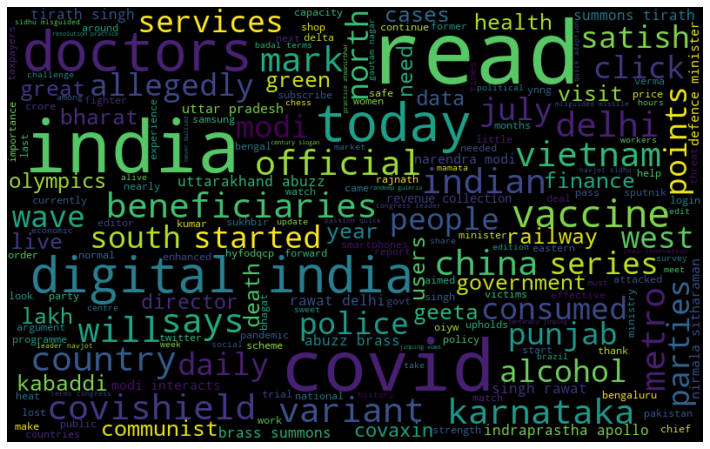

In [17]:
all_words=" ".join([sentence for sentence in df['Clean_Data']])
graph(all_words)

# 4) instantiate model distil bert

In [18]:
def getBERTSentiment(score):
    if score>4:
        return 'Positive'           
    elif score<2:
        return 'Negative'        
    else:
        return 'Neutral'        

In [19]:
import torch
import requests
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [20]:
tokenizer=AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [21]:
def sentiment_score(tweets):
    tokens=tokenizer.encode(tweets,return_tensors='pt')
    result=model(tokens)
    return int(torch.argmax(result.logits))+1

In [22]:
df_new['BERT_Score']=df['Clean_Data'].apply(lambda x: sentiment_score(x[:512]))  
df_new

,id,Clean_Data,BERT_Score
0,1,spot registration walk facility sputnik curren...,1
1,2,indraprastha apollo started administration spu...,1
2,3,indian military developing capabilities deal w...,5
3,4,shop night consumed little alcohol doctors cam...,1
4,5,doctors went bhagat singh verma shop gautam na...,1
...,...,...,...
95,96,britain starts planning vaccine booster shots ...,1
96,97,delhi newly appointed commissioner police bala...,4
97,98,chess abhimanyumishra abhimanyu mishra becomes...,5
98,99,mayoral primary thrown into chaos officials bu...,1


In [24]:
#df_new['distilBERT_Sentiment']=df['distilBERT'].apply(lambda x: getSentiment(x[:512]))  
df_new['BERT_Sentiment']=df_new['BERT_Score'].apply(getBERTSentiment)
df_new

,id,Clean_Data,BERT_Score,BERT_Sentiment
0,1,spot registration walk facility sputnik curren...,1,Negative
1,2,indraprastha apollo started administration spu...,1,Negative
2,3,indian military developing capabilities deal w...,5,Positive
3,4,shop night consumed little alcohol doctors cam...,1,Negative
4,5,doctors went bhagat singh verma shop gautam na...,1,Negative
...,...,...,...,...
95,96,britain starts planning vaccine booster shots ...,1,Negative
96,97,delhi newly appointed commissioner police bala...,4,Neutral
97,98,chess abhimanyumishra abhimanyu mishra becomes...,5,Positive
98,99,mayoral primary thrown into chaos officials bu...,1,Negative


# 5) using polarity from textBlob

In [25]:
#function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
#Create polarity
df_new['Polarity']=df_new['Clean_Data'].apply(getPolarity)
#show the new dataframe
df_new.head()

,id,Clean_Data,BERT_Score,BERT_Sentiment,Polarity
0,1,spot registration walk facility sputnik curren...,1,Negative,0.000000
1,2,indraprastha apollo started administration spu...,1,Negative,0.000000
2,3,indian military developing capabilities deal w...,5,Positive,-0.100000
3,4,shop night consumed little alcohol doctors cam...,1,Negative,-0.270833
4,5,doctors went bhagat singh verma shop gautam na...,1,Negative,-0.108333


In [26]:
def getPolaritySentiment(score):
    if score>0:
        return 'Positive'           
    elif score<0:
        return 'Negative'        
    else:
        return 'Neutral'   

In [27]:
#create a function to compute negative, neutral and positve analysis         
df_new['Polarity_Sentiment']=df_new['Polarity'].apply(getPolaritySentiment)
#show the dataframe
df_new.head()

,id,Clean_Data,BERT_Score,BERT_Sentiment,Polarity,Polarity_Sentiment
0,1,spot registration walk facility sputnik curren...,1,Negative,0.000000,Neutral
1,2,indraprastha apollo started administration spu...,1,Negative,0.000000,Neutral
2,3,indian military developing capabilities deal w...,5,Positive,-0.100000,Negative
3,4,shop night consumed little alcohol doctors cam...,1,Negative,-0.270833,Negative
4,5,doctors went bhagat singh verma shop gautam na...,1,Negative,-0.108333,Negative


# 6) Graphical Representation of Outputs and Differences

In [28]:
def graphOP(types):
    plt.title('Sentiment Analysis using '+types)
    plt.xlabel(types)
    plt.ylabel('Counts')
    df_new[types].value_counts().plot(kind='bar',color='red')
    plt.show()
    a=df_new[types].value_counts()
    print(a)    

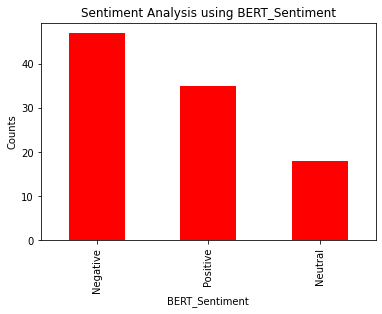

Negative    47
Positive    35
Neutral     18
Name: BERT_Sentiment, dtype: int64


In [29]:
type1='BERT_Sentiment'
graphOP(type1)

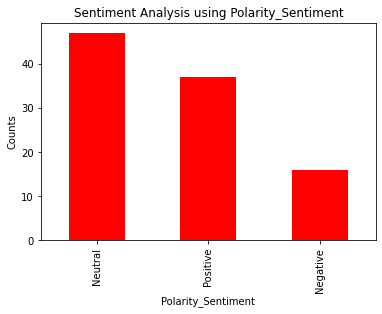

Neutral     47
Positive    37
Negative    16
Name: Polarity_Sentiment, dtype: int64


In [30]:
type2='Polarity_Sentiment'
graphOP(type2)

# Similarity in the results in the both the types of comparison

In [32]:
BERT_MEAN = df_new['BERT_Score'].mean()
print(BERT_MEAN)
print("The overall sentiment is ",getBERTSentiment(BERT_MEAN))

2.83
The overall sentiment is  Neutral


In [33]:
Polarity_MEAN = int(df_new['Polarity'].mean())
print(Polarity_MEAN)
print("The overall sentiment is ", getPolaritySentiment(Polarity_MEAN))

0
The overall sentiment is  Neutral
